In [1]:
# Written by: Tanya Wen 2020/08/05
# use SPM to do analysis after fmriprep
# useful resources: https://miykael.github.io/nipype_tutorial/
# based on example from: https://github.com/niflows/nipype1-examples/blob/master/package/niflow/nipype1/examples/fmri_nipy_glm.py
# and: https://nipype.readthedocs.io/en/latest/users/examples/fmri_spm.html

from builtins import str
from builtins import range

from nipype.interfaces.nipy.model import FitGLM, EstimateContrast
from nipype.interfaces.nipy.preprocess import ComputeMask

import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.spm as spm  # spm
import nipype.interfaces.matlab as mlab  # how to run matlab
import nipype.interfaces.utility as util  # utility
import nipype.pipeline.engine as pe  # pipeline engine
import nipype.algorithms.rapidart as ra  # artifact detection
import nipype.algorithms.modelgen as model  # model specification

from os.path import join as opj
import os  # system functionsimport nipype.interfaces.io as nio  # Data i/o
import shutil # move files

from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from nipype.caching import Memory #idk why this is here, but it keeps things from crashing due to memory
mem = Memory(base_dir='.')

In [2]:
# Set the way matlab should be called
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

In [3]:
# Specify the location of the data.
datadir = '/media/tw260/X6/Effort/fMRI_BIDS/derivatives/fmriprep'
outputdir = '/media/tw260/X6/Effort/analysis/workingdir-Effort-Model2'
# Specify the subject directories
subject_list = ['s01','s02','s03','s04','s05','s06','s08','s09','s10','s11','s12','s13','s14','s15','s16','s18','s19','s20','s23','s24','s25','s26','s27','s29','s31']
subject_num = [x.replace('s','') for x in subject_list]


In [4]:
# Convert .nii..gz to .nii for SPM and drop dummy scans

from nipype.algorithms.misc import Gunzip
from nipype import MapNode

for i in range(len(subject_list)):
    # current subject
    cur_sub = subject_list[i]
    # Functional scans
    #I have 5 runs per person, so this iterates through each run
    for j in range(0,5):
        # find the source epi
        cur_task = "effort"
        if not os.path.isfile(os.path.join(outputdir, cur_sub, "func", "sub-%s_run-%d.nii"%(cur_sub, j+1))):

            # gunzip
            nii_gz = "sub-%s_task-%s_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"%(cur_sub, cur_task, j+1)
            print(nii_gz)
            gunzip_in_file = os.path.join(datadir, "sub-%s"%cur_sub, "func", nii_gz)

            gunzip = MapNode(Gunzip(), name='gunzip', iterfield=['in_file'])
            gunzip.inputs.in_file = gunzip_in_file
            gunzip_res = gunzip.run()

            gunzip_out_file = "sub-%s_task-%s_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii"%(cur_sub, cur_task, j+1)
            shutil.move(gunzip_res.outputs.out_file[0], os.path.join(datadir, "sub-%s"%cur_sub, "func", gunzip_out_file))

            # remove dummy scans
            from nipype.interfaces.fsl import ExtractROI
            #We decided to ask the scanner to keep the 5 dummies, so we need to manually discard them
            extract = MapNode(ExtractROI(t_min=5, t_size=-1, output_type='NIFTI'),name="extract", iterfield=['in_file'])  

            extract.inputs.in_file = os.path.join(datadir, "sub-%s"%cur_sub, "func", gunzip_out_file)
            extract_res = extract.run()
            res_out_file = "sub-%s_run-%d.nii"%(cur_sub, j+1)
            os.makedirs(os.path.join(outputdir, cur_sub, "func"), exist_ok=True)
            shutil.move(extract_res.outputs.roi_file[0], os.path.join(outputdir, cur_sub, "func", res_out_file))




In [5]:
# Here we set up iteration over all the subjects.
infosource = pe.Node(
    interface=util.IdentityInterface(fields=['subject_id']), name="infosource")# Specify the location of the data.

infosource.iterables = ('subject_id', subject_list)

In [6]:
# get data (mmore info on DataGrabbler can be found here: https://nipype.readthedocs.io/en/0.11.0/users/grabbing_and_sinking.html)
datasource = pe.Node(
    interface=nio.DataGrabber(
        infields=['subject_id'], outfields=['func']),
    name='datasource')
datasource.inputs.base_directory = outputdir
datasource.inputs.template = '*'
datasource.inputs.field_template = dict(func='%s/func/sub-%s_run-%s.nii')
datasource.inputs.template_args =  dict(func=[['subject_id', 'subject_id', ['1','2','3','4','5']]])
datasource.inputs.sort_filelist = True

In [7]:
# Smooth the functional data using nipype.interfaces.spm.Smooth.
# Use two different smoothing kernels
smooth = pe.Node(interface=spm.Smooth(), name="smooth")
fwhmlist = [0,10]
smooth.iterables = ('fwhm', fwhmlist)

In [8]:
#Here we create a function that returns subject-specific information about the experimental paradigm. This is used by the nipype.interfaces.spm.SpecifyModel to create the information necessary to generate an SPM design matrix. 
def subjectinfo(subject_id):
    from nipype.interfaces.base import Bunch
    from copy import deepcopy
    import os  # system functionsimport nipype.interfaces.io as nio  # Data i/o
    import pandas as pd
    #this allows FSL to access the data according to BIDS format
    bids_dir = '/media/tw260/X6/Effort/fMRI_BIDS/'
    model_dir = '/media/tw260/X6/Effort/behav'
    print("Subject ID: %s\n" % str(subject_id))

    task_id = "effort"

    output = []
    for r in range(5):
        #this pulls up the confound file from fmriprep
        confounds = pd.read_csv(os.path.join(bids_dir, "derivatives", "fmriprep", 
        "sub-%s"%subject_id.replace('_',''), "func", 
        "sub-%s_task-%s_run-%s_desc-confounds_timeseries.tsv"%(subject_id.replace('_',''), task_id, r+1)),
        sep="\t", na_values="n/a", skiprows=range(1,6))


        #get the behavioral data to make the glm
        events = pd.read_csv(os.path.join(model_dir, subject_id, "Effort_run-%02d_events_Model2.csv"%(r+1)))

        output.insert(r,
                    Bunch(
                    #first we have our condition, events, their durations, etc
                    conditions=['cue-easy_easy',
                                'cue-easy_hard',
                                'cue-hard_easy',
                                'cue-hard_hard',
                                'task-easy_easy',
                                'task-easy_hard',
                                'task-hard_easy',
                                'task-hard_hard',
                                'cue-first',
                                'task-first',
                                'error'],
                    onsets=[list(events[events.trial_type == 'cue-easy_easy'].onset),
                            list(events[events.trial_type == 'cue-easy_hard'].onset),
                            list(events[events.trial_type == 'cue-hard_easy'].onset),
                            list(events[events.trial_type == 'cue-hard_hard'].onset),
                            list(events[events.trial_type == 'task-easy_easy'].onset),
                            list(events[events.trial_type == 'task-easy_hard'].onset),
                            list(events[events.trial_type == 'task-hard_easy'].onset),
                            list(events[events.trial_type == 'task-hard_hard'].onset),
                            list(events[events.trial_type == 'cue-first'].onset),
                            list(events[events.trial_type == 'task-first'].onset),
                            list(events[events.trial_type == 'error'].onset)],
                    durations=[list(events[events.trial_type == 'cue-easy_easy'].duration),
                            list(events[events.trial_type == 'cue-easy_hard'].duration),
                            list(events[events.trial_type == 'cue-hard_easy'].duration),
                            list(events[events.trial_type == 'cue-hard_hard'].duration),
                            list(events[events.trial_type == 'task-easy_easy'].duration),
                            list(events[events.trial_type == 'task-easy_hard'].duration),
                            list(events[events.trial_type == 'task-hard_easy'].duration),
                            list(events[events.trial_type == 'task-hard_hard'].duration),
                            list(events[events.trial_type == 'cue-first'].duration),
                            list(events[events.trial_type == 'task-first'].duration),
                            list(events[events.trial_type == 'error'].duration)],
                    #we can add in regressors we care to mode. Here I add in some confounds from the file
                    #note, I start the iteration at '5' because of how many initial slices we throw away (2 sec TR)
                    regressors=[list(confounds.trans_x),
                                list(confounds.trans_y),
                                list(confounds.trans_z),
                                list(confounds.rot_x),
                                list(confounds.rot_y),
                                list(confounds.rot_z)
                                ],
                    regressor_names=['trans_x',
                                    'trans_y',
                                    'trans_z',
                                    'rot_x',
                                    'rot_y',
                                    'rot_z'],
                    amplitudes=None,
                    tmod=None,
                    pmod=None))

    return output

In [9]:
# Setup the contrast structure that needs to be evaluated. This is a list of lists. The inner list specifies the contrasts and has the following format - [Name,Stat,[list of condition names],[weights on those conditions]. The condition names must match the names listed in the subjectinfo function described above.

#specify the contrasts you care about
all_cond_names = ['cue-easy_easy', 'cue-easy_hard', 'cue-hard_easy', 'cue-hard_hard',
'task-easy_easy', 'task-easy_hard', 'task-hard_easy', 'task-hard_hard']


regressor = [0] * len(all_cond_names)
regressor[0] = 1
cue_easy_easy = ('cue_easy_easy','T',all_cond_names,regressor) #1

regressor = [0] * len(all_cond_names)
regressor[1] = 1
cue_easy_hard = ('cue_easy_hard','T',all_cond_names,regressor) #2

regressor = [0] * len(all_cond_names)
regressor[2] = 1
cue_hard_easy = ('cue_hard_easy','T',all_cond_names,regressor) #3

regressor = [0] * len(all_cond_names)
regressor[3] = 1
cue_hard_hard = ('cue_hard_hard','T',all_cond_names,regressor) #4

regressor = [0] * len(all_cond_names)
regressor[0] = 0.5
regressor[1] = 0.5
regressor[2] = -0.5
regressor[3] = -0.5
cue_main_effect_prev_E = ('cue_main_effect_prev_E','T',all_cond_names,regressor) #5

regressor = [0] * len(all_cond_names)
regressor[0] = -0.5
regressor[1] = -0.5
regressor[2] = 0.5
regressor[3] = 0.5
cue_main_effect_prev_H = ('cue_main_effect_prev_H','T',all_cond_names,regressor) #6

regressor = [0] * len(all_cond_names)
regressor[0] = 0.5
regressor[1] = -0.5
regressor[2] = 0.5
regressor[3] = -0.5
cue_main_effect_current_E = ('cue_main_effect_current_E','T',all_cond_names,regressor) #7

regressor = [0] * len(all_cond_names)
regressor[0] = -0.5
regressor[1] = 0.5
regressor[2] = -0.5
regressor[3] = 0.5
cue_main_effect_current_H = ('cue_main_effect_current_H','T',all_cond_names,regressor) #8

regressor = [0] * len(all_cond_names)
regressor[0] = 1
regressor[2] = -1
cue_StayEasy_vs_Switch2Easy = ('cue_StayEasy_vs_Switch2Easy','T',all_cond_names,regressor) #9

regressor = [0] * len(all_cond_names)
regressor[0] = -1
regressor[2] = 1
cue_Switch2Easy_vs_StayEasy = ('cue_Switch2Easy_vs_StayEasy','T',all_cond_names,regressor) #10

regressor = [0] * len(all_cond_names)
regressor[3] = 1
regressor[1] = -1
cue_StayHard_vs_Switch2Hard = ('cue_StayHard_vs_Switch2Hard','T',all_cond_names,regressor) #11

regressor = [0] * len(all_cond_names)
regressor[3] = -1
regressor[1] = 1
cue_Switch2Hard_vs_StayHard = ('cue_Switch2Hard_vs_StayHard','T',all_cond_names,regressor) #12




regressor = [0] * len(all_cond_names)
regressor[4] = 1
task_easy_easy = ('task_easy_easy','T',all_cond_names,regressor) #13

regressor = [0] * len(all_cond_names)
regressor[5] = 1
task_easy_hard = ('task_easy_hard','T',all_cond_names,regressor) #14

regressor = [0] * len(all_cond_names)
regressor[6] = 1
task_hard_easy = ('task_hard_easy','T',all_cond_names,regressor) #15

regressor = [0] * len(all_cond_names)
regressor[7] = 1
task_hard_hard = ('task_hard_hard','T',all_cond_names,regressor) #16

regressor = [0] * len(all_cond_names)
regressor[4] = 0.5
regressor[5] = 0.5
regressor[6] = -0.5
regressor[7] = -0.5
task_main_effect_prev_E = ('task_main_effect_prev_E','T',all_cond_names,regressor) #17

regressor = [0] * len(all_cond_names)
regressor[4] = -0.5
regressor[5] = -0.5
regressor[6] = 0.5
regressor[7] = 0.5
task_main_effect_prev_H = ('task_main_effect_prev_H','T',all_cond_names,regressor) #18

regressor = [0] * len(all_cond_names)
regressor[4] = 0.5
regressor[5] = -0.5
regressor[6] = 0.5
regressor[7] = -0.5
task_main_effect_current_E = ('task_main_effect_current_E','T',all_cond_names,regressor) #19

regressor = [0] * len(all_cond_names)
regressor[4] = -0.5
regressor[5] = 0.5
regressor[6] = -0.5
regressor[7] = 0.5
task_main_effect_current_H = ('task_main_effect_current_H','T',all_cond_names,regressor) #20

regressor = [0] * len(all_cond_names)
regressor[4] = 1
regressor[6] = -1
task_StayEasy_vs_Switch2Easy = ('task_StayEasy_vs_Switch2Easy','T',all_cond_names,regressor) #21

regressor = [0] * len(all_cond_names)
regressor[4] = -1
regressor[6] = 1
task_Switch2Easy_vs_StayEasy = ('task_Switch2Easy_vs_StayEasy','T',all_cond_names,regressor) #22

regressor = [0] * len(all_cond_names)
regressor[7] = 1
regressor[5] = -1
task_StayHard_vs_Switch2Hard = ('task_StayHard_vs_Switch2Hard','T',all_cond_names,regressor) #23

regressor = [0] * len(all_cond_names)
regressor[7] = -1
regressor[5] = 1
task_Switch2Hard_vs_StayHard = ('task_Switch2Hard_vs_StayHard','T',all_cond_names,regressor) #24


contrasts = [cue_easy_easy, cue_easy_hard, cue_hard_easy, cue_hard_hard, cue_main_effect_prev_E, cue_main_effect_prev_H, cue_main_effect_current_E, cue_main_effect_current_H, cue_StayEasy_vs_Switch2Easy, cue_Switch2Easy_vs_StayEasy, cue_StayHard_vs_Switch2Hard, cue_Switch2Hard_vs_StayHard, 
task_easy_easy, task_easy_hard, task_hard_easy, task_hard_hard, task_main_effect_prev_E, task_main_effect_prev_H, task_main_effect_current_E, task_main_effect_current_H, task_StayEasy_vs_Switch2Easy, task_Switch2Easy_vs_StayEasy, task_StayHard_vs_Switch2Hard, task_Switch2Hard_vs_StayHard]



In [10]:
# Generate design information using nipype.interfaces.spm.SpecifyModel. nipy accepts only design specified in seconds so “output_units” has always have to be set to “secs”.
modelspec = pe.Node(interface=model.SpecifySPMModel(), name="modelspec")
modelspec.inputs.concatenate_runs = False
modelspec.inputs.input_units = 'secs'
modelspec.inputs.output_units = 'secs'
modelspec.inputs.time_repetition = 2
modelspec.inputs.high_pass_filter_cutoff = 128

In [11]:
# Generate a first level SPM.mat file for analysis nipype.interfaces.spm.Level1Design.
level1design = pe.Node(interface=spm.Level1Design(), name="level1design")
level1design.inputs.timing_units = modelspec.inputs.output_units
level1design.inputs.interscan_interval = modelspec.inputs.time_repetition
level1design.inputs.bases = {'hrf': {'derivs': [0, 0]}}

In [12]:
# Use nipype.interfaces.spm.EstimateModel to determine the parameters of the model.
level1estimate = pe.Node(interface=spm.EstimateModel(), name="level1estimate")
level1estimate.inputs.estimation_method = {'Classical': 1}

In [13]:
# Use nipype.interfaces.spm.EstimateContrast to estimate the first level contrasts specified in a few steps above.
contrastestimate = pe.Node(
    interface=spm.EstimateContrast(), name="contrastestimate")
contrastestimate.inputs.contrasts = contrasts
contrastestimate.overwrite = True
contrastestimate.config = {'execution': {'remove_unnecessary_outputs': False}}

In [14]:
# Setup the pipeline
# The nodes created above do not describe the flow of data. They merely describe the parameters used for each function. In this section we setup the connections between the nodes such that appropriate outputs from nodes are piped into appropriate inputs of other nodes.

l1pipeline = pe.Workflow(name="level1")
l1pipeline.base_dir = os.path.abspath("/media/tw260/X6/Effort/analysis/workingdir-Effort-Model2")

l1pipeline.connect(
    [(infosource, datasource, [('subject_id', 'subject_id')]),
     (datasource, smooth, [('func', 'in_files')]),
     (smooth, modelspec,[('smoothed_files', 'functional_runs')]), 
     (infosource, modelspec, [(("subject_id", subjectinfo), "subject_info")]), 
     (modelspec, level1design, [('session_info', 'session_info')]),
     (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]),
     (level1estimate, contrastestimate,[('spm_mat_file', 'spm_mat_file'), ('beta_images', 'beta_images'),('residual_image', 'residual_image')])])



220805-10:16:34,363 nipype.workflow INFO:
	 Generated workflow graph: /media/tw260/X6/Effort/analysis/workingdir-Effort-Model2/level1/graph.png (graph2use=colored, simple_form=True).


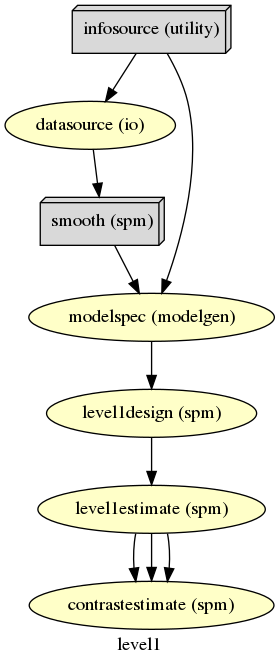

In [15]:
# Create pipeline output graph
l1pipeline.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1pipeline.base_dir, 'level1', 'graph.png'))


In [16]:
# Setup storage results
# Use nipype.interfaces.io.DataSink to store selected outputs from the pipeline in a specific location. This allows the user to selectively choose important output bits from the analysis and keep them.
# The first step is to create a datasink node and then to connect outputs from the modules above to storage locations. These take the following form directory_name[.[@]subdir] where parts between [] are optional. For example ‘realign.@mean’ below creates a directory called realign in ‘l1output/subject_id/’ and stores the mean image output from the Realign process in the realign directory. If the @ is left out, then a sub-directory with the name ‘mean’ would be created and the mean image would be copied to that directory.

datasink = pe.Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.abspath('/media/tw260/X6/Effort/analysis/l1output-Effort-Model2')


def getstripdir(subject_id):
    import os
    return os.path.join(
        os.path.abspath('/media/tw260/X6/Effort/analysis/workingdir-Effort-Model2'),
        '_subject_id_%s' % subject_id)


# store relevant outputs from various stages of the 1st level analysis
l1pipeline.connect([
    (infosource, datasink, [('subject_id', 'container'),
                            (('subject_id', getstripdir), 'strip_dir')]),
    (level1design, datasink, [('spm_mat_file', 'model.pre-estimate')]),
    (level1estimate, datasink, [('spm_mat_file', 'model.@spm'), ('beta_images', 'model.@beta'),
                            ('mask_image', 'model.@mask'), ('residual_image', 'model.@res'),
                            ('RPVimage', 'model.@rpv')]),
    (contrastestimate, datasink, [('spm_mat_file', 'contrasts.@spm'),
                                  ('con_images', 'contrasts.@con'),
                                  ('spmT_images', 'contrasts.@T')]),
])


In [17]:
# Use nipype.interfaces.io.DataGrabber to extract the contrast ges across a group of first level subjects. Unlike the previous pipeline that iterated over subjects, this pipeline will iterate over

# collect all the con images for each contrast.
contrast_ids = list(range(1, len(contrasts) + 1))
l2source = pe.Node(nio.DataGrabber(infields=['fwhm', 'con']), name="l2source")
# we use .*i* to capture both .img (SPM8) and .nii (SPM12)
l2source.inputs.template = os.path.abspath(
    '/media/tw260/X6/Effort/analysis/l1output-Effort-Model2/*/con*/*/_fwhm_%d/con_%04d.*i*')
# iterate over all contrast images
l2source.iterables = [('fwhm', fwhmlist), ('con', contrast_ids)]
l2source.inputs.sort_filelist = True


In [18]:
# Use nipype.interfaces.spm.OneSampleTTestDesign to perform a simple statistical analysis of the contrasts from the group of n this example).
# setup a 1-sample t-test node
onesamplettestdes = pe.Node(
    interface=spm.OneSampleTTestDesign(), name="onesampttestdes")
l2estimate = pe.Node(interface=spm.EstimateModel(), name="level2estimate")
l2estimate.inputs.estimation_method = {'Classical': 1}
l2conestimate = pe.Node(
    interface=spm.EstimateContrast(), name="level2conestimate")
cont1 = ('Group', 'T', ['mean'], [1])
l2conestimate.inputs.contrasts = [cont1]
l2conestimate.inputs.group_contrast = True


In [19]:
# As before, we setup a pipeline to connect these two nodes (l2source lettest).
l2pipeline = pe.Workflow(name="level2")
l2pipeline.base_dir = os.path.abspath('/media/tw260/X6/Effort/analysis/l2output-Effort-Model2')
l2pipeline.connect([
    (l2source, onesamplettestdes, [('outfiles', 'in_files')]),
    (onesamplettestdes, l2estimate, [('spm_mat_file', 'spm_mat_file')]),
    (l2estimate, l2conestimate, [('spm_mat_file', 'spm_mat_file'), ('beta_images', 'beta_images'),
                                ('residual_image', 'residual_image')]),
])

In [20]:
# Execute the pipeline
if __name__ == '__main__':
    l1pipeline.run('MultiProc')
    l2pipeline.run('MultiProc')

220805-10:17:14,597 nipype.workflow INFO:
	 Workflow level1 settings: ['check', 'execution', 'logging', 'monitoring']
Subject ID: s31

Subject ID: s31

Subject ID: s29

Subject ID: s29

Subject ID: s27

Subject ID: s27

Subject ID: s26

Subject ID: s26

Subject ID: s25

Subject ID: s25

Subject ID: s24

Subject ID: s24

Subject ID: s23

Subject ID: s23

Subject ID: s20

Subject ID: s20

Subject ID: s19

Subject ID: s19

Subject ID: s18

Subject ID: s18

Subject ID: s16

Subject ID: s16

Subject ID: s15

Subject ID: s15

Subject ID: s14

Subject ID: s14

Subject ID: s13

Subject ID: s13

Subject ID: s12

Subject ID: s12

Subject ID: s11

Subject ID: s11

Subject ID: s10

Subject ID: s10

Subject ID: s09

Subject ID: s09

Subject ID: s08

Subject ID: s08

Subject ID: s06

Subject ID: s06

Subject ID: s05

Subject ID: s05

Subject ID: s04

Subject ID: s04

Subject ID: s03

Subject ID: s03

Subject ID: s02

Subject ID: s02

Subject ID: s01

Subject ID: s01

220805-10:17:23,722 nipype.workf

In [21]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/media/tw260/X6/Effort/fMRI commands/crash-20220805-085936-tw260-level1design.a1.b00-b98c5892-5a4e-4966-9149-c99ebdab4833.pklz')
print(res)

OSError: Result file /media/tw260/X6/Effort/fMRI commands/crash-20220805-085936-tw260-level1design.a1.b00-b98c5892-5a4e-4966-9149-c99ebdab4833.pklz expected, but does not exist after (5.0) seconds.